<a href="https://colab.research.google.com/github/Mjcherono/Sendy_Umoja_Hackathon/blob/main/Sendy_UmojaHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Starter Notebook for;
## UmojaHack Africa 2021 #2: Sendy - Delivery Rider Response Challenge by UmojaHack Africa

Can you predict who is the best delivery rider for an order placed via logistics company Sendy?

![Umoja Hack](https://zindpublic.blob.core.windows.net/public/uploads/competition/image/152/thumb_c5ec4e2a-e000-4176-a93c-dd1143c2b60f.png)

The objective of this challenge is to create a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them.

**Projet Overview**

The dataset provided by Sendy includes order dispatch details and rider metrics based on orders made on the Sendy platform. The challenge is to predict the reaction of a partner rider to an order: is a rider most likely to ignore, decline or accept the dispatch they receive?

Sendy provides an API as well as a web and mobile application platform to link customers who have delivery needs with vetted transporters. The customers select their vehicle of choice, get their price quote upfront and pay using various payment options. The system optimises the route, looks for the closest available riders and dispatches the orders in the most efficient way.

The training dataset provided here is a subset of over 200,000 dispatches and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. All data in this subset have been fully anonymized while preserving the distribution.

**Objectives.**

Build a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them.



#### Variable definitions

#### Dispatch Data

**ID** - Unique ID for each order request

**order_id** – Unique number identifying the order

**client_id** - Unique number identifying the customer on a platform

**client_type** - Specifies the customer type (Business or Personal)

**rider_id** - Unique number to uniquely identify the rider

**rider_license_status** - Identifies riders who have a license to access restricted areas i.e. 0 (Cannot access a restricted area) and 1 (Can access a restricted area)

**rider_carrier_type** - Identifies the box option that a rider currently has i.e. 0 (No Box option) and 1 (Box option)

**rider_amount** - The earnings a partner would earn if they successfully complete an order.

**order_license_status** - Identifies orders that require a pick-up or drop-off in a restricted area i.e. 0 (Restricted area) and 1 (Non-Restricted area)

**order_carrier_type** - Identifies the box option the customer specified while placing their orders i.e. 0 (No box option), 1 (Box option), 2 (Any option)

**vendor_type** – For this competition limited to bikes. However, in practice, Sendy’s service extends to Vans and Trucks.

**Pickup Latitude and Longitude (pickup_lat and pickup_long)** - Latitude and longitude of pick up location

**Destination Latitude and Longitude (drop_off_lat and drop_off_long**) - Latitude and longitude of delivery location

**Rider Latitude and Longitude (rider_lat and rider_long)** - Latitude and longitude of the Rider at the time of dispatch.

**target** - The reaction of a rider in regards to a particular dispatch. Did a rider ignore (0), decline (1) or accept (2) a dispatch?


#### Dispatch times

**dispatch_day** - Day of Month i.e. 1-31

**dispatch_day_of_week** - Weekday (Monday = 1)

**dispatch_time** - Time of day the dispatch was sent out to the riders

In [484]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
pd.set_option('max_colwidth', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [485]:
# Load files
train1 = pd.read_csv('/content/Train.csv')
test1 = pd.read_csv('/content/Test.csv')
riders1 = pd.read_csv('/content/Riders.csv')
ss1 = pd.read_csv('/content/SampleSubmission.csv')

In [486]:
#copies
train = train1.copy()
test = test1.copy()
riders = riders1.copy()
ss = ss1.copy()

In [487]:
# check data shapes
train.shape, test.shape, riders.shape, ss.shape

((179867, 21), (76791, 20), (2632, 4), (76791, 2))

In [488]:
# Preview train
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0


In [489]:
# Preview riders
riders.head()

,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,16261,308,21.05,321
1,8832,224,10.00,27
2,53866,238,17.76,25
3,46368,343,24.56,320
4,45609,399,14.97,214


#### Data Preprocessing


*   Merge
*   check for null values
*   check for duplicates
*   Anomalies and outliers








In [490]:
# Separate target variable 
target = train['target']

In [491]:
# Drop target column then join Train and test
train.drop('target',axis = 1, inplace = True)

# Merge the train and test dataframe
frames = [train,test]
data = pd.concat(frames)

In [492]:
# Checking unique values and number of rows asigned for each column in the dataset
for i in data.columns:
  
  print('\n')
  
  print(i,data[i].nunique())

  print(i,data[i].unique())



ID 256658
ID ['ID_SCUW21PVAU' 'ID_2HA7X30JMN' 'ID_IAJWDTBY6M' ... 'ID_VDI8L0SWNS'
 'ID_7L22AF1T6K' 'ID_LMMA33Q7YL']


order_id 64326
order_id [ 4435 32711  8712 ... 11467 12867 12617]


dispatch_day 31
dispatch_day [27 30 14 22  3 18 28 20  6 12 17  7  5  1 15 31 16  4 25 19 11 23 21  9
 13 10 26  2  8 29 24]


dispatch_day_of_week 7
dispatch_day_of_week [6 7 2 3 5 4 1]


dispatch_time 5788
dispatch_time ['09:02:54' '13:01:37' '10:01:00' ... '06:09:58' '20:08:49' '05:09:47']


client_id 5457
client_id [ 593630  837729  695129 ...  676936 2533910 2361571]


client_type 2
client_type ['Business' 'Personal']


order_license_status 2
order_license_status [0 1]


order_carrier_type 3
order_carrier_type [2 1 0]


vendor_type 1
vendor_type ['Bike']


rider_id 775
rider_id [ 30153  20884  33143  96531 103546  66125  66033  45701 117622  40066
  74842  93610   9729 117093  80132  93633 117760 115184  62445 118082
  76406   5865 118588 100441   7383 105892  66010 106398 100855  64561
  53521  

### Feature Engineering.

Rider Amount Class

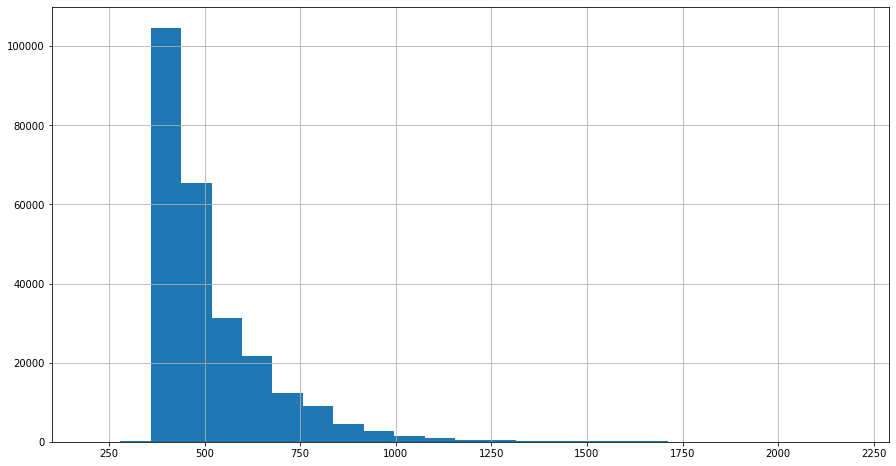

In [493]:
#distribution of this class
h = data.rider_amount.hist(bins=25, figsize=[15, 8])

In [494]:
import numpy as np
# create a list of our conditions
conditions = [
    (data['rider_amount'] <= 390),
    (data['rider_amount'] > 390) & (data['rider_amount'] <= 650),
    (data['rider_amount'] > 650) & (data['rider_amount'] <= 820),
    (data['rider_amount'] > 800) & (data['rider_amount'] <= 1200)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '4', '3', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
data['rider_amount_range'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4


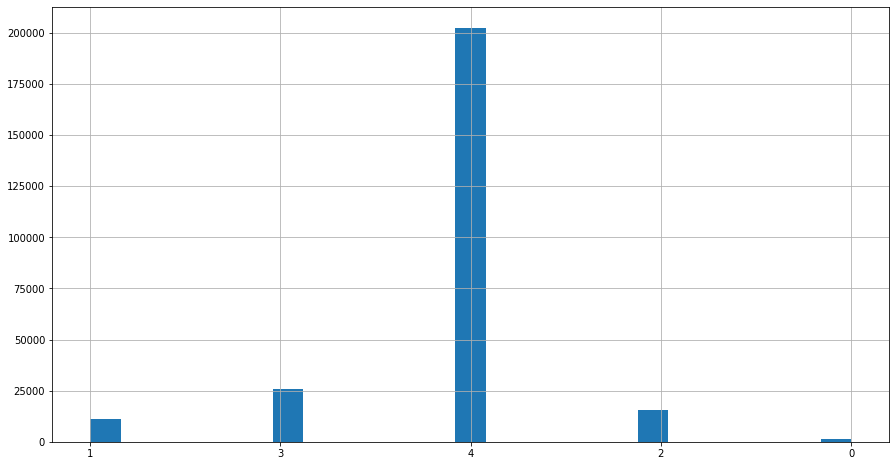

In [495]:
#distribution of this class
m = data.rider_amount_range.hist(bins=25, figsize=[15, 8])

Day of the month.

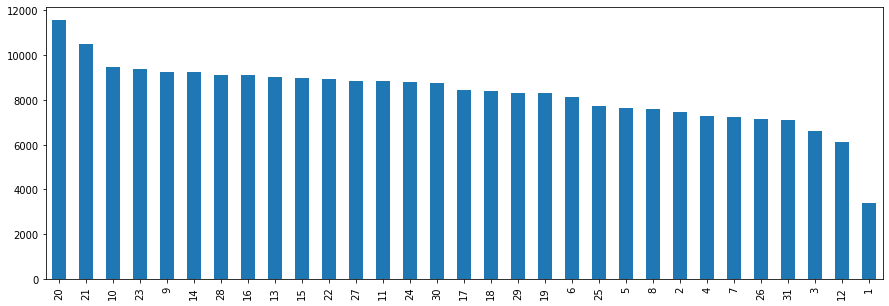

In [496]:
# Dispatches frequency per day of month
data['dispatch_day'].value_counts().plot(kind='bar',figsize=[15,5])

In [497]:
#list for the conditions
conditions = [
    (data['dispatch_day'] == 1),
    (data['dispatch_day'] > 1) & (data['dispatch_day'] <= 6),
    (data['dispatch_day'] > 6) & (data['dispatch_day'] <= 8),
    (data['dispatch_day'] >8)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2','3','4']

# create a new column and use np.select to assign values to it using our lists as arguments
data['dispatch_day_range'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4


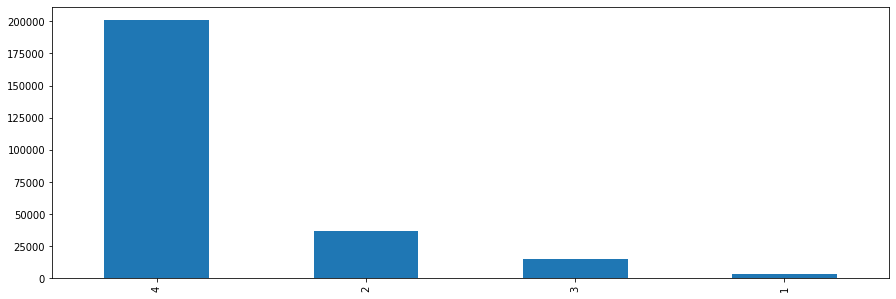

In [498]:
data['dispatch_day_range'].value_counts().plot(kind='bar',figsize=[15,5])

Weekends.

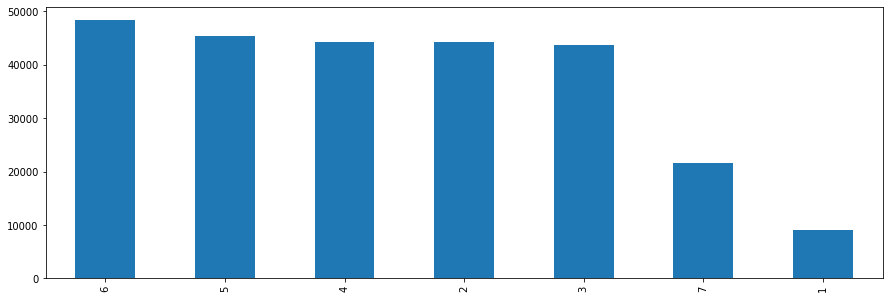

In [499]:
#Frequency per day of the week
data['dispatch_day_of_week'].value_counts().plot(kind='bar',figsize=[15,5])

In [500]:
# create a list of our conditions
conditions = [
    (data['dispatch_day_of_week'] == 1),
    (data['dispatch_day_of_week'] == 7)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
data['weekend'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0


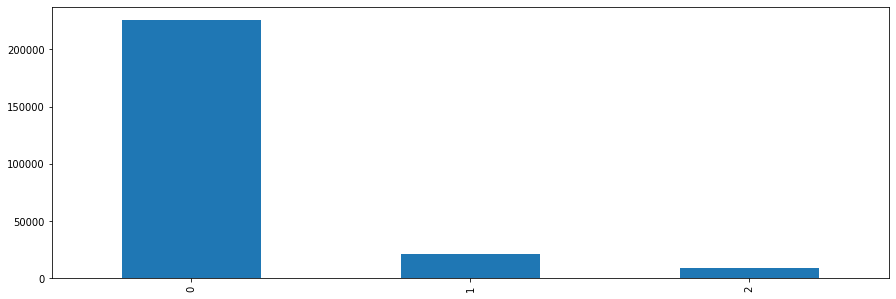

In [501]:
#Frequency per day of the week
data['weekend'].value_counts().plot(kind='bar',figsize=[15,5])

Busy Hours.

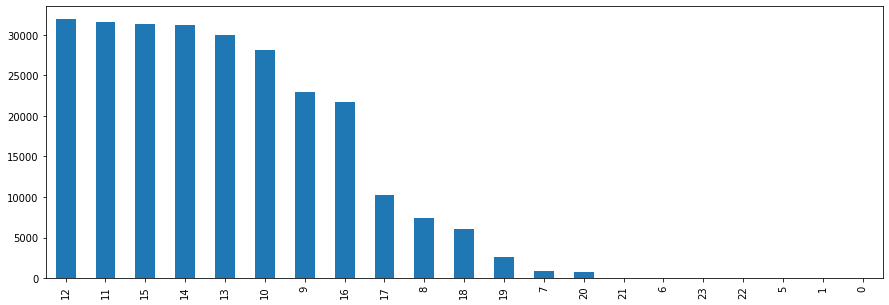

In [502]:
# Convert time column to datetime
data['dispatch_time'] = pd.to_datetime(data['dispatch_time'])

# Extract Hour Column
data['dispatch_hour'] = data['dispatch_time'].dt.hour

# Let's view the hourly distribution of dispatches
data['dispatch_hour'].value_counts().plot(kind='bar',figsize=[15,5])

In [503]:
# Let's get the cos and cosine of our Time Variable
time_column = ["dispatch_time"]

for col in time_column:
  data[col.split('_')[0] + '_hour_sine'] = np.sin(2 * np.pi * data[col].dt.hour/24)
  data[col.split('_')[0] + '_hour_cos'] = np.cos(2* np.pi * data[col].dt.hour/24)

In [504]:
data.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926
2,ID_IAJWDTBY6M,8712,14,2,2021-04-03 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025
3,ID_LKSVPNYMTR,44869,22,3,2021-04-03 14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,4,4,0,14,-0.500000,-0.866025
4,ID_O7N8Y918YH,57590,27,5,2021-04-03 16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,4,4,0,16,-0.866025,-0.500000


In [505]:
# create a list of our conditions

conditions = [
    (data['dispatch_hour'] <= 6),
    (data['dispatch_hour'] > 8) & (data['dispatch_hour'] <= 16),
    (data['dispatch_hour'] > 16) & (data['dispatch_hour'] <= 20),
    (data['dispatch_hour'] > 20)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '4', '3', '2']

# create a new column and use np.select to assign values to it using our lists as arguments
data['busy_hours'] = np.select(conditions, values)

# display updated DataFrame
data.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4


Geo Distance.


In [506]:
# Calculate distance between coordinates

def distance_calc(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    AVG_EARTH_RADIUS = 6371  # in km
    
    lat = lat2 - lat1
    
    lng = lng2 - lng1
    
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h

In [507]:
# variables for the distances between the locations of the riders, pickup points and dropoff points
data['rider_dropoff_dist'] = distance_calc(data.rider_lat, data.rider_long, data.drop_off_lat, data.drop_off_long)
data['rider_pickup_dist'] = distance_calc(data.rider_lat, data.rider_long, data.pickup_lat, data.pickup_long)
data['pickup_dropoff_dist'] = distance_calc(data.pickup_lat, data.pickup_long, data.drop_off_lat, data.drop_off_long)

Distances Ranges.

Pickup and Drop-off ranges.

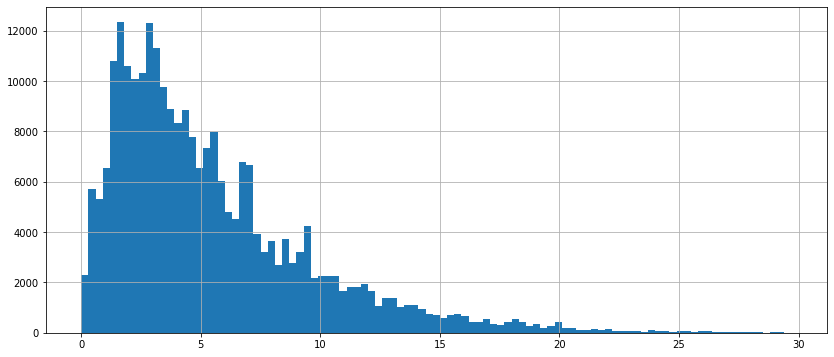

In [508]:
#distribution of the distance between pickup and drop off locations

#bin_values = np.arange(start=-0, stop=60, step=0.3)
data['pickup_dropoff_dist'].hist(bins=bin_values, figsize=[14,6])

In [509]:
#list of our conditions

conditions = [
    (data['pickup_dropoff_dist'] <= 6),
    (data['pickup_dropoff_dist'] > 6) & (data['pickup_dropoff_dist'] <= 16),
    (data['pickup_dropoff_dist'] > 16) & (data['pickup_dropoff_dist'] <= 30),
    (data['pickup_dropoff_dist'] > 30) & (data['pickup_dropoff_dist'] <= 50),
    (data['pickup_dropoff_dist'] > 50)
    ]

# create a list of the values we want to assign for each condition
values = ['5','4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
data['pickup_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
data.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4


Rider - Pickup ranges

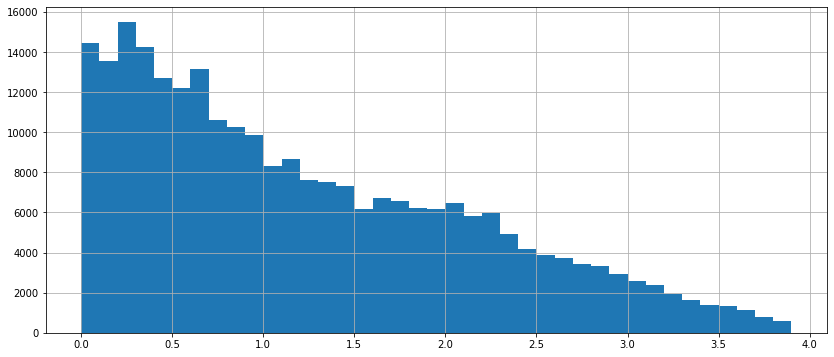

In [510]:
#Distribution of the distance between the rider and pick up location


bin_values = np.arange(start=-0, stop=4, step=0.1)
data['rider_pickup_dist'].hist(bins=bin_values, figsize=[14,6])

In [511]:
# create a list of our conditions
conditions = [
    (data['rider_pickup_dist'] <= 1),
    (data['rider_pickup_dist'] > 1) & (data['rider_pickup_dist'] <= 1.5),
    (data['rider_pickup_dist'] > 1.5) & (data['rider_pickup_dist'] <= 2.5),
    (data['rider_pickup_dist'] > 2.5) & (data['rider_pickup_dist'] <= 3.7),
    (data['rider_pickup_dist'] > 3.7)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
data['rider_pickup_dist_range'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1
2,ID_IAJWDTBY6M,8712,14,2,2021-04-03 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,7.224872,1.846564,5.421337,5,3


Rider Drop off Ranges

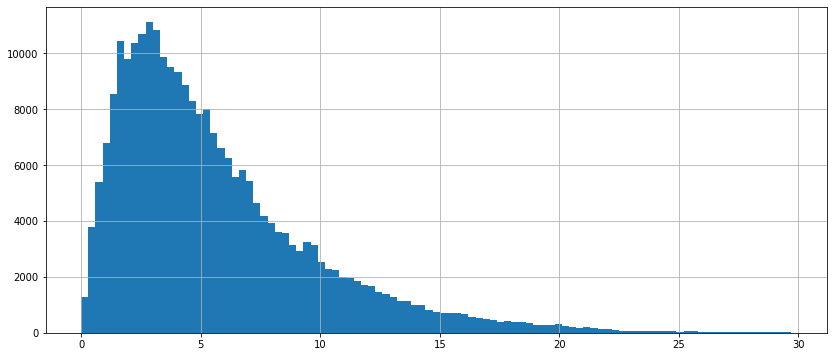

In [512]:
# Let's also visualize the distance between the rider and drop off location

bin_values = np.arange(start=-0, stop=30, step=0.3)
data['rider_dropoff_dist'].hist(bins=bin_values, figsize=[14,6])

In [513]:
# create a list of our conditions
conditions = [
    (data['rider_dropoff_dist'] <= 5),
    (data['rider_dropoff_dist'] > 5) & (data['rider_dropoff_dist'] <= 10),
    (data['rider_dropoff_dist'] > 10) & (data['rider_dropoff_dist'] <= 18),
    (data['rider_dropoff_dist'] > 18) & (data['rider_dropoff_dist'] <= 30),
    (data['rider_dropoff_dist'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
data['rider_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3,3
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1,3
2,ID_IAJWDTBY6M,8712,14,2,2021-04-03 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,7.224872,1.846564,5.421337,5,3,2


Time and Distance.

In [514]:
# create a list of our conditions
conditions = [
    (data['rider_dropoff_dist_range'] == '5') & (data['busy_hours'] == '1'),
    (data['rider_dropoff_dist_range'] == '4') & (data['busy_hours'] == '2'),
    (data['rider_dropoff_dist_range'] == '3') & (data['busy_hours'] == '3'),
    (data['rider_dropoff_dist_range'] == '2') & (data['busy_hours'] == '4'),
    (data['rider_dropoff_dist_range'] == '1') & (data['busy_hours'] == '4'),
    (data['rider_dropoff_dist_range'] == '2') & (data['busy_hours'] == '0')
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','6','5']

# create a new column and use np.select to assign values to it using our lists as arguments
data['time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
data.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3,3,0
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1,3,0


Weekday vs Time_distance



In [515]:
# create a list of our conditions
conditions = [
    (data['dispatch_day_of_week'] == '1') & (data['time_distance_bias'] == '5'), # Sunday  early morning & average distance
    (data['dispatch_day_of_week'] == '7') & (data['time_distance_bias'] == '3'), # Saturday late night & long distance
    (data['dispatch_day_of_week'] == '7') & (data['time_distance_bias'] == '5'), # Saturday early morning average distance
    (data['dispatch_day_of_week'] == '0') & (data['time_distance_bias'] == '3'), # Weekday late night & long distance
    (data['dispatch_day_of_week'] == '0') & (data['time_distance_bias'] == '6')  # Weekday daytime and average distance
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
data['weekend_time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
data.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3,3,0,0
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1,3,0,0
2,ID_IAJWDTBY6M,8712,14,2,2021-04-03 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,7.224872,1.846564,5.421337,5,3,2,4,0
3,ID_LKSVPNYMTR,44869,22,3,2021-04-03 14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,4,4,0,14,-0.500000,-0.866025,4,4.626603,0.557483,4.609312,5,1,1,6,0
4,ID_O7N8Y918YH,57590,27,5,2021-04-03 16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,4,4,0,16,-0.866025,-0.500000,4,1.693870,0.954647,1.554900,5,1,1,6,0


Money Earned VS time & Distance



In [516]:
# create a list of our conditions

conditions = [
    (data['rider_amount_range'] == '4') & (data['busy_hours'] == '4'),
    (data['rider_pickup_dist_range'] == '3') & (data['busy_hours'] == '2'),
    (data['rider_pickup_dist_range'] == '1') & (data['rider_amount_range'] == '4'),
    (data['rider_pickup_dist_range'] == '4') & (data['rider_amount_range'] == '4')
    ]

# create a list of the values we want to assign for each condition
values = ['4','2','6','1']

# create a new column and use np.select to assign values to it using our lists as arguments
data['money_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
data.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias,money_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2021-04-03 09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3,3,0,0,0
1,ID_2HA7X30JMN,32711,30,7,2021-04-03 13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1,3,0,0,0
2,ID_IAJWDTBY6M,8712,14,2,2021-04-03 10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,7.224872,1.846564,5.421337,5,3,2,4,0,4


In [517]:
#confirming all dtypes are numerica

data[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']] = data[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']].apply(pd.to_numeric)

In [518]:
# # Merge rider dataset to train and test sets
# train = train.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')
# test = test.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')

# # Preview merged dataframe
# train.head()

In [519]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (179867, 20)
The shape of the test set is: (76791, 20)


### Data Cleaning.

#### Missing Values.

In [520]:
# print(train.isnull().sum())

# print(test.isnull().sum())

# #There are no missing values

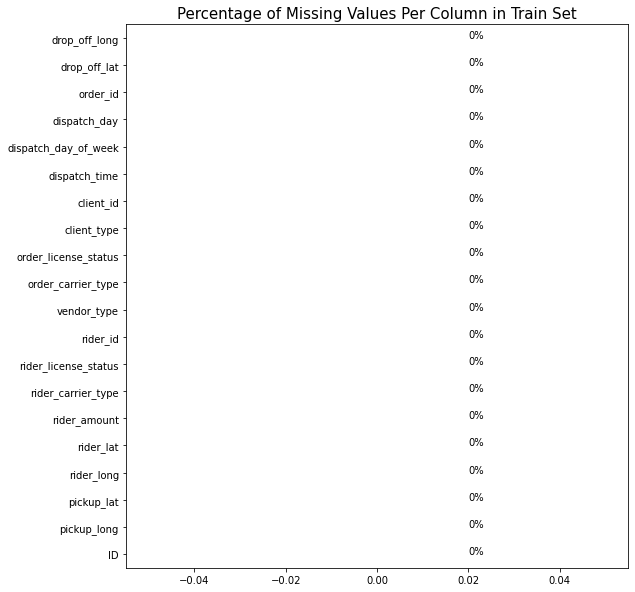

In [521]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

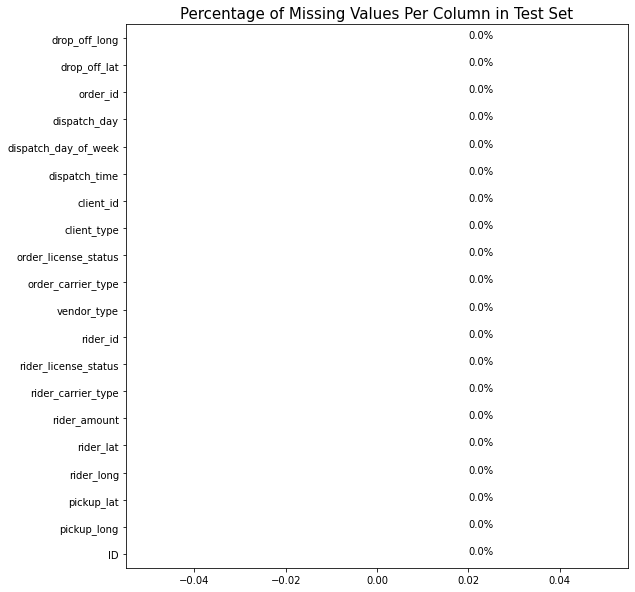

In [522]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [523]:
# Check for duplicates
print(train.duplicated().any(), test.duplicated().any())
#There are no duplicates

False False


#### Visualizing the target variable

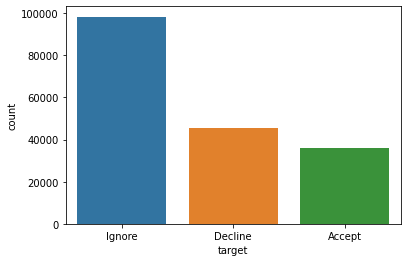

In [524]:
h = sns.countplot(train1['target'])
h.set_xticklabels(['Ignore','Decline','Accept'])
plt.show()

Correlation.

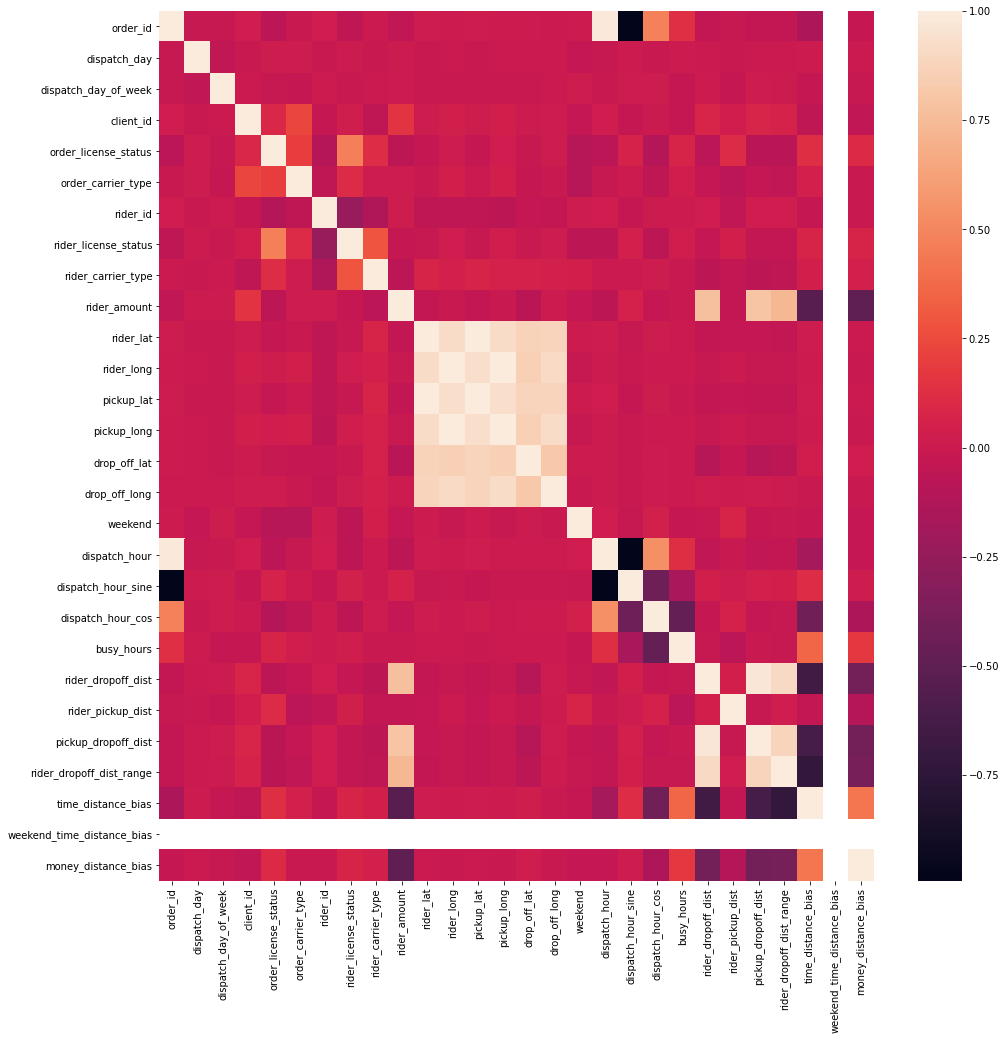

In [525]:
plt.figure(figsize = (16,16))
sns.heatmap(data.corr(), xticklabels = data.corr().columns, yticklabels = data.corr().columns)

Concatenating the latitudes and longitudes.

In [526]:
# from math import radians, cos, sin, asin, sqrt
# def haversine(lon1, lat1, lon2, lat2):
#     """
#     Calculate the great circle distance between two points 
#     on the earth (specified in decimal degrees)
#     """
#     # convert decimal degrees to radians 
#     lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
#     # haversine formula 
#     dlon = lon2 - lon1 
#     dlat = lat2 - lat1 
#     a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#     c = 2 * asin(sqrt(a)) 
#     # Radius of earth in kilometers is 6371
#     km = 6371* c
#     return km

# # Creating a new column to generate the output by passing lat long information to Haversine Equation
# train['rider_pickup_distance'] = [haversine(train.rider_long[i],train.rider_lat[i],train.pickup_long[i],train.pickup_lat[i]) for i in range(len(train))]
# train['rider_pickup_distance'] = train['rider_pickup_distance'].round(decimals=3)
# #for the distance between rider and drop-off
# train['rider_dropoff_distance'] = [haversine(train.rider_long[i],train.rider_lat[i],train.drop_off_long[i],train.drop_off_lat[i]) for i in range(len(train))]
# train['rider_dropoff_distance'] = train['rider_dropoff_distance'].round(decimals=3)
# #For the difference between the pick up and  drop off distances
# train['pickup_dropoff_distance'] = [haversine(train.pickup_long[i],train.pickup_lat[i],train.drop_off_long[i],train.drop_off_lat[i]) for i in range(len(train))]
# train['pickup_dropoff_distance'] = train['pickup_dropoff_distance'].round(decimals=3)
# # Printing the data table 
# print(train.head(3))

# # Creating a new column to generate the output by passing lat long information to Haversine Equation
# test['rider_pickup_distance'] = [haversine(test.rider_long[i],test.rider_lat[i],test.pickup_long[i],test.pickup_lat[i]) for i in range(len(test))]
# test['rider_pickup_distance'] = test['rider_pickup_distance'].round(decimals=3)
# #for the distance between rider and drop-off
# test['rider_dropoff_distance'] = [haversine(test.rider_long[i],test.rider_lat[i],test.drop_off_long[i],test.drop_off_lat[i]) for i in range(len(test))]
# test['rider_dropoff_distance'] = test['rider_dropoff_distance'].round(decimals=3)
# #For the difference between the pick up and  drop off distances
# test['pickup_dropoff_distance'] = [haversine(test.pickup_long[i],test.pickup_lat[i],test.drop_off_long[i],test.drop_off_lat[i]) for i in range(len(test))]
# test['pickup_dropoff_distance'] = test['pickup_dropoff_distance'].round(decimals=3)
# # Printing the data table 
# print(test.head())

### SMOTE - Synthetic Minority Oversampling Technique

Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors' algorithm to generate new and synthetic data we can use for training our model.

In [527]:
# # import SMOTE 
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state = 25, sampling_strategy = 1.0)   # again we are eqalizing both the classes

# X = train.drop('target', axis=1).values
# y = train['target'].values

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state=300)

# # fit the sampling
# X_train, y_train = sm.fit_sample(X_train, y_train)





### Building Model

In [528]:
X

,ID,order_id,dispatch_day,dispatch_day_of_week,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias,money_distance_bias
0,ID_SCUW21PVAU,4435,27,6,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4,16.076117,1.746491,14.426076,4,3,3,0,0,0
1,ID_2HA7X30JMN,32711,30,7,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4,13.417651,0.394373,13.126454,4,1,3,0,0,0
2,ID_IAJWDTBY6M,8712,14,2,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0,10,0.500000,-0.866025,4,7.224872,1.846564,5.421337,5,3,2,4,0,4
3,ID_LKSVPNYMTR,44869,22,3,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,4,4,0,14,-0.500000,-0.866025,4,4.626603,0.557483,4.609312,5,1,1,6,0,4
4,ID_O7N8Y918YH,57590,27,5,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,4,4,0,16,-0.866025,-0.500000,4,1.693870,0.954647,1.554900,5,1,1,6,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179862,ID_ZSG11STPCJ,15779,9,4,2029175,Personal,0,2,Bike,117093,0,1,530,-42.799022,-17.263385,-42.797847,-17.257129,-42.821718,-17.302860,4,4,0,10,0.500000,-0.866025,4,4.091213,0.526936,4.578447,5,1,1,6,0,4
179863,ID_25CK50OBPT,4574,15,2,75647,Business,0,1,Bike,70196,1,1,430,-42.824439,-17.273777,-42.821400,-17.272752,-42.786174,-17.281706,4,4,0,9,0.707107,-0.707107,4,4.303764,0.348087,3.984492,5,1,1,6,0,4
179864,ID_MFL3T3X89C,22882,13,7,62560,Personal,1,2,Bike,93909,1,1,490,-42.840226,-17.265304,-42.824923,-17.280676,-42.778648,-17.298742,4,4,1,11,0.258819,-0.965926,4,7.370410,2.113469,5.352416,5,3,2,4,0,4
179865,ID_JVG80JGEI7,56816,13,2,36869,Business,0,2,Bike,66033,1,1,500,-42.817205,-17.338171,-42.836143,-17.317200,-42.790718,-17.258187,4,4,0,16,-0.866025,-0.500000,4,7.159128,2.712786,6.977458,4,4,2,4,0,4


In [529]:
# Split data

# Split train and test set
train = data.iloc[:179867, :]
test = data.iloc[179867:, :]

# # Selecting the columns to be used as data for accuracy testing
# cols = ['dispatch_day','dispatch_day_of_week','order_license_status','order_carrier_type','rider_carrier_type','rider_amount',
#         'rider_amount_range','dispatch_day_range','weekend','dispatch_hour','rider_dropoff_dist','rider_pickup_dist','pickup_dropoff_dist',
#         'pickup_dropoff_dist_range','rider_pickup_dist_range','rider_dropoff_dist_range','time_distance_bias','weekend_time_distance_bias','money_distance_bias']
cols = [col for col in train.columns if col not in ['dispatch_time']]

# Set the target and independent variables
X = train[cols]
y = target


In [530]:
test.drop(['dispatch_time'],axis = 1, inplace=True)


In [531]:
# Train a model
model = LGBMClassifier(random_state=3031)

# Since Catboost accepts categorical features we'll make then identifiable to the model 
categorical_features_indices = np.where(X.dtypes != np.float)[0]

## Fitting our data to the model
model.fit(X,y,cat_features = categorical_features_indices)

# Making Predictions
y_pred = model.predict(test)
model.score(X,y)

# # Making Predictions
# y_pred = model.predict(test)
# model.score(X,y)

# # Make predictions
# y_pred = model.predict(test)

# # Check score
# accuracy_score(y, y_pred)


TypeError: ignored

#### Tuned Light GBM Model

In [ ]:
# # Split data
# main_cols = train.columns.difference(['id', 'order_id', 'rider_id', 'target', 'dispatch_time',	'client_id','vendor_type_Bike','year']).tolist()
# X = train[main_cols]
# y = train.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3031)

# # Feature scaling
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

# #building the model
# clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=n_HP_points_to_test,
#     scoring='roc_auc',
#     cv=3,
#     refit=True,
#     random_state=314,
#     verbose=True)




### Cat Boost Classifier.

In [425]:
# Lets install catboost for creating a model
#!pip install catboost

     |████████████████████████████████| 67.3MB 54kB/s 


In [426]:
# Split train and test set
train = data.iloc[:179867, :]
test = data.iloc[179867:, :]

# Selecting the columns to be used as data for accuracy testing
cols = [col for col in train.columns if col not in ['dispatch_time']]

# Set the target and independent variables
X = train[cols]
y = target

test.drop(['dispatch_time'],axis = 1, inplace=True)

# Fitting the data to model
from catboost import CatBoostClassifier

# You can increase the iterations parameter but it will take longer to learn
model = CatBoostClassifier(iterations = 1000, early_stopping_rounds = 50)

# Here we fit our data then make predictions
import numpy as np

# Since Catboost accepts categorical features we'll make then identifiable to the model 
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Fitting our data to the model
model.fit(X,y,cat_features=categorical_features_indices)

# Making Predictions
y_pred = model.predict(test)
model.score(X,y)

Learning rate set to 0.103116
0:	learn: 1.0555740	total: 2.09s	remaining: 34m 49s
1:	learn: 1.0219143	total: 4.63s	remaining: 38m 31s
2:	learn: 0.9949572	total: 6.82s	remaining: 37m 47s
3:	learn: 0.9642473	total: 8.73s	remaining: 36m 13s
4:	learn: 0.9396263	total: 10.9s	remaining: 36m 12s
5:	learn: 0.9188001	total: 12.7s	remaining: 35m 7s
6:	learn: 0.9004581	total: 14.8s	remaining: 35m 2s
7:	learn: 0.8867315	total: 16.8s	remaining: 34m 41s
8:	learn: 0.8732753	total: 18.7s	remaining: 34m 14s
9:	learn: 0.8575159	total: 20.9s	remaining: 34m 32s
10:	learn: 0.8446390	total: 23.4s	remaining: 35m
11:	learn: 0.8329312	total: 25.6s	remaining: 35m 4s
12:	learn: 0.8229992	total: 27.9s	remaining: 35m 19s
13:	learn: 0.8140529	total: 30.1s	remaining: 35m 19s
14:	learn: 0.8069249	total: 32.5s	remaining: 35m 30s
15:	learn: 0.8002803	total: 34.8s	remaining: 35m 42s
16:	learn: 0.7918144	total: 36.9s	remaining: 35m 34s
17:	learn: 0.7840037	total: 39s	remaining: 35m 25s
18:	learn: 0.7788780	total: 41.1s	r

0.021204556700228503